In [ ]:
# install transformer
!pip install transformers

In [ ]:
!pip3 install emoji==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-0.6.0-py3-none-any.whl size=49720 sha256=142f53db421f721d2e7011bf74e4e69103747c47ca8422076a362d7a490b59fe
  Stored in directory: /root/.cache/pip/wheels/1b/bd/d9/310c33c45a553798a714e27e3b8395d37128425442b8c78e07
Successfully built emoji


In [ ]:
import re
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from torch.utils.data import DataLoader, TensorDataset, RandomSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Train data
train_df= pd.read_csv("/content/drive/MyDrive/Research NLP/research_data/sent_train.csv")
train_df.head(5)

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0


In [ ]:
# Validate data
validate_df= pd.read_csv("/content/drive/MyDrive/Research NLP/research_data/sent_valid.csv")
validate_df.head(5)

,text,label
0,$ALLY - Ally Financial pulls outlook https://t...,0
1,"$DELL $HPE - Dell, HPE targets trimmed on comp...",0
2,$PRTY - Moody's turns negative on Party City h...,0
3,$SAN: Deutsche Bank cuts to Hold,0
4,$SITC: Compass Point cuts to Sell,0


In [ ]:
# Clean text column
def clean_text(text):
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    # Remove special characters
    # text = re.sub(r"[^\w\s]", "", text)
    # Lowercasing
    text = text.lower()
    return text

train_df['clean_text'] = train_df['text'].apply(clean_text)
validate_df['clean_text'] = validate_df['text'].apply(clean_text)

In [ ]:
train_df.head(5)

,text,label,clean_text
0,$BYND - JPMorgan reels in expectations on Beyo...,0,$bynd - jpmorgan reels in expectations on beyo...
1,$CCL $RCL - Nomura points to bookings weakness...,0,$ccl $rcl - nomura points to bookings weakness...
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0,"$cx - cemex cut at credit suisse, j.p. morgan ..."
3,$ESS: BTIG Research cuts to Neutral https://t....,0,$ess: btig research cuts to neutral
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0,$fnko - funko slides after piper jaffray pt cut


In [ ]:
validate_df.head(5)

,text,label,clean_text
0,$ALLY - Ally Financial pulls outlook https://t...,0,$ally - ally financial pulls outlook
1,"$DELL $HPE - Dell, HPE targets trimmed on comp...",0,"$dell $hpe - dell, hpe targets trimmed on comp..."
2,$PRTY - Moody's turns negative on Party City h...,0,$prty - moody's turns negative on party city
3,$SAN: Deutsche Bank cuts to Hold,0,$san: deutsche bank cuts to hold
4,$SITC: Compass Point cuts to Sell,0,$sitc: compass point cuts to sell


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

def plot_class_dist_chart(df, run_mode):
    # Explore the distribution of classes
    # For train set
    train_class_distribution = Counter(df['label'])
    print("Class Distribution of train dataset:", train_class_distribution)

    # Convert the Counter object to a DataFrame for easier plotting
    class_dist_df = pd.DataFrame.from_dict(train_class_distribution, orient='index').reset_index()
    class_dist_df.columns = ['Class', 'Count']

    # Defining the plot size
    plt.figure(figsize=(5, 5))

    # Defining the values for x-axis, y-axis and creating the barplot
    plots = sns.barplot(x='Class', y='Count', data=class_dist_df)

    # Iterating over the bars one-by-one
    for bar in plots.patches:
        # Using Matplotlib's annotate function and
        # passing the coordinates where the annotation shall be done
        plots.annotate(format(bar.get_height(), '.2f'),
                      (bar.get_x() + bar.get_width() / 2,
                       bar.get_height()), ha='center', va='center',
                      size=12, xytext=(0, 5),
                      textcoords='offset points')

    # Setting the title for the graph
    plt.title("{} data class-wise data count".format(run_mode))

    # Finally showing the plot
    plt.show()


Class Distribution of train dataset: Counter({2: 6178, 1: 1923, 0: 1442})


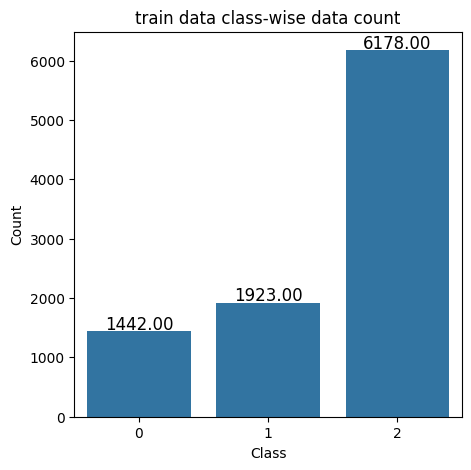

Class Distribution of train dataset: Counter({2: 1566, 1: 475, 0: 347})


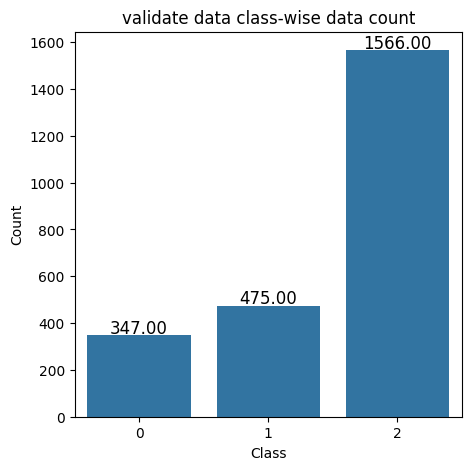

In [ ]:
# Clean text column
counter=0
for df in [train_df, validate_df]:
    if counter == 0:
        run_mode="train"
    else:
        run_mode="validate"
    plot_class_dist_chart(df, run_mode)
    counter+=1

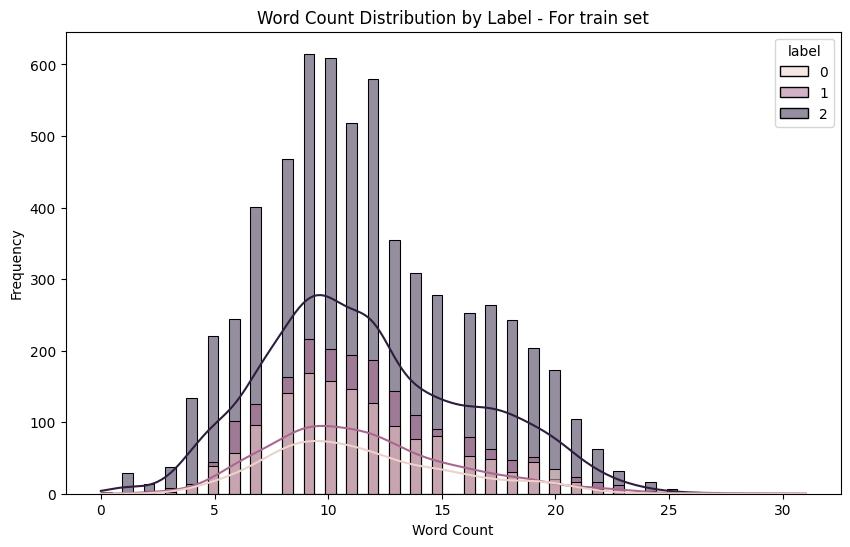

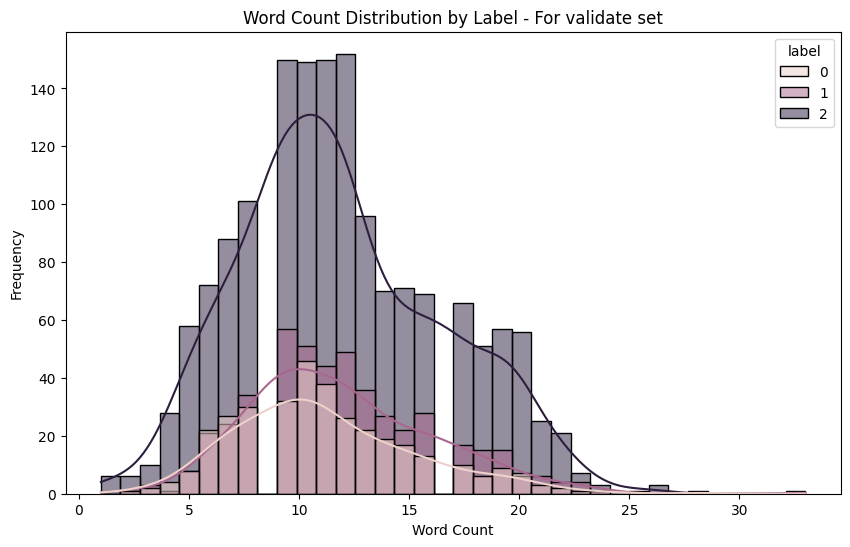

In [ ]:
# Perform text data analysis - Word count distribution
def word_count_distribution(df,run_mode):
    df['word_count'] = df['clean_text'].apply(lambda x: len(str(x).split()))
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='word_count', hue='label', kde=True)
    plt.title('Word Count Distribution by Label - For {} set'.format(run_mode))
    plt.xlabel('Word Count')
    plt.ylabel('Frequency')
    plt.show()
# Calling word count distribution function
word_count_distribution(train_df,"train")
word_count_distribution(validate_df,"validate")

Wordcloud on train set


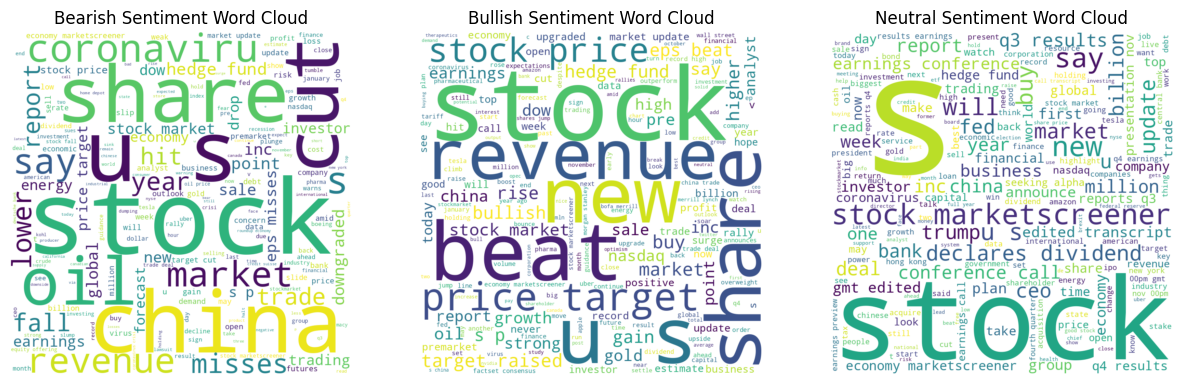

Wordcloud on validate set


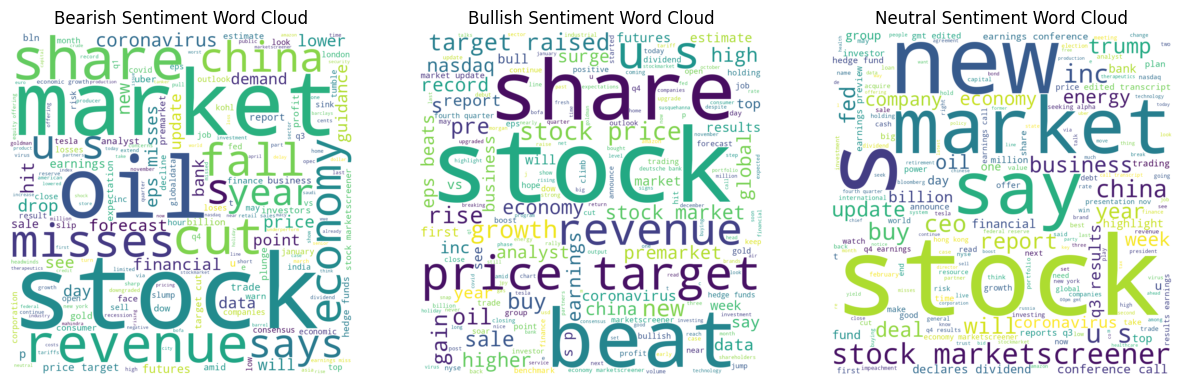

In [ ]:
# Creating wordcloud for train set for three sentiment labels - Bearish, Bullish and Neutral tweets
def generate_word_cloud(df):
    bearish_tweets = " ".join(df[df['label'] == 0]['clean_text'])
    bullish_tweets = " ".join(df[df['label'] == 1]['clean_text'])
    neutral_tweets = " ".join(df[df['label'] == 2]['clean_text'])

    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    wordcloud = WordCloud(width=1000, height=1000, background_color='white').generate(bearish_tweets)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Bearish Sentiment Word Cloud')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    wordcloud = WordCloud(width=1000, height=1000, background_color='white').generate(bullish_tweets)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Bullish Sentiment Word Cloud')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    wordcloud = WordCloud(width=1000, height=1000, background_color='white').generate(neutral_tweets)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Neutral Sentiment Word Cloud')
    plt.axis('off')

    plt.show()

# Generating wordclouds for train and validate datasets
counter=0
for df in [train_df,validate_df]:
    # setting title of plots
    if counter==0:
        print("Wordcloud on train set")
    else:
        print("Wordcloud on validate set")
    counter+=1
    generate_word_cloud(df)

In [ ]:
#  Treating class imbalance and using combination of both oversampler and undersampler
def handle_class_imbalance(df):
    oversampler = RandomOverSampler(sampling_strategy='auto')
    undersampler = RandomUnderSampler(sampling_strategy='auto')

    X = df['clean_text'].values.reshape(-1, 1)
    y = df['label']

    X_over, y_over = oversampler.fit_resample(X, y)
    X_balanced, y_balanced = undersampler.fit_resample(X_over, y_over)

    df_balanced = pd.DataFrame({'clean_text': X_balanced.flatten(), 'label': y_balanced})
    return df_balanced

In [ ]:
lst_df=[]
for df in [train_df, validate_df]:
    final_df = handle_class_imbalance(df)
    lst_df.append(final_df)

train_final_df = lst_df[0]
validate_final_df = lst_df[1]

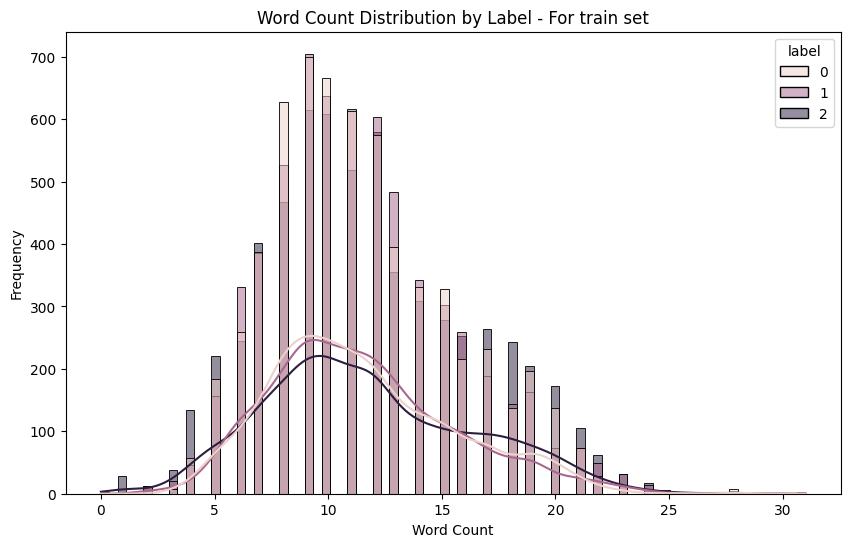

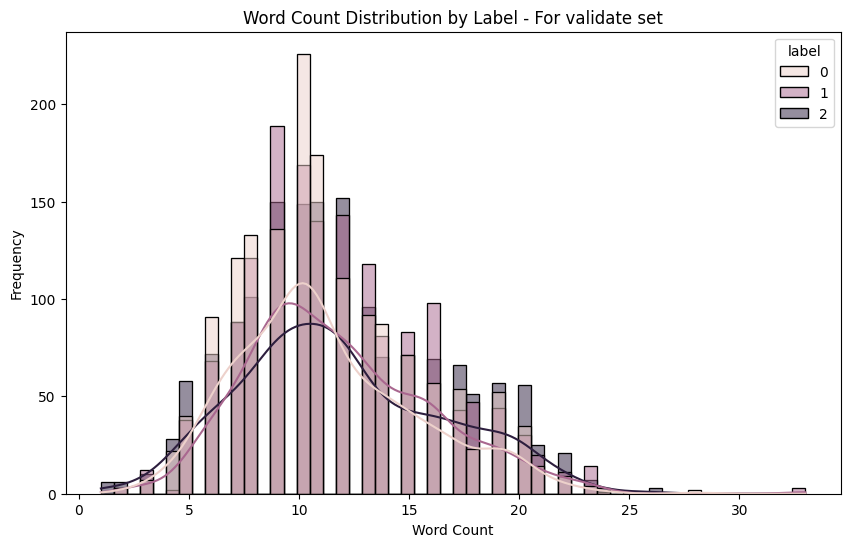

In [ ]:
# Perform text data analysis - Word count distribution
def word_count_distribution(df,run_mode):
    df['word_count'] = df['clean_text'].apply(lambda x: len(str(x).split()))
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='word_count', hue='label', kde=True)
    plt.title('Word Count Distribution by Label - For {} set'.format(run_mode))
    plt.xlabel('Word Count')
    plt.ylabel('Frequency')
    plt.show()
# Calling word count distribution function
word_count_distribution(train_final_df,"train")
word_count_distribution(validate_final_df,"validate")

In [ ]:
train_final_df.head(5)

,clean_text,label,word_count
0,$bynd - jpmorgan reels in expectations on beyo...,0,9
1,$ccl $rcl - nomura points to bookings weakness...,0,13
2,"$cx - cemex cut at credit suisse, j.p. morgan ...",0,13
3,$ess: btig research cuts to neutral,0,6
4,$fnko - funko slides after piper jaffray pt cut,0,9


In [ ]:
validate_final_df.head(5)

,clean_text,label,word_count
0,$ally - ally financial pulls outlook,0,6
1,"$dell $hpe - dell, hpe targets trimmed on comp...",0,10
2,$prty - moody's turns negative on party city,0,8
3,$san: deutsche bank cuts to hold,0,6
4,$sitc: compass point cuts to sell,0,6


In [ ]:
X = list(train_final_df['clean_text'])
y = list(train_final_df['label'])

In [ ]:
# Split the data into training and validation sets
X_train, X_test,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [ ]:
import torch
from transformers import BertweetTokenizer, RobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
import numpy
#from datasets import Dataset
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# tested in transformers==4.18.0, pytorch==1.7.1
import torch
import transformers
torch.__version__, transformers.__version__

('2.3.1+cu121', '4.42.4')

In [ ]:
torch.cuda.is_available()

True

In [ ]:
# Load the BERTweet tokenizer and model
tokenizer = BertweetTokenizer.from_pretrained('vinai/bertweet-base')
model = RobertaForSequenceClassification.from_pretrained('vinai/bertweet-base', num_labels=3)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.91M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch
from transformers import BertweetTokenizer, RobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import matplotlib.pyplot as plt

In [ ]:
# Function to tokenize data
def tokenize_data(texts, labels):
    input_ids = []
    attention_masks = []
    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=64,  # Adjust this based on your data
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)
    return input_ids, attention_masks, labels

# Tokenize the data
train_input_ids, train_attention_masks, train_labels = tokenize_data(X_train, y_train)
test_input_ids, test_attention_masks, test_labels = tokenize_data(X_test, y_test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# Create TensorDataset
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

# Create DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Define optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
total_steps = len(train_dataloader) * 3  # Assuming 3 epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 Step 0/927 Loss 1.03560209274292
Epoch 1 Step 10/927 Loss 1.0602046251296997
Epoch 1 Step 20/927 Loss 1.072041392326355
Epoch 1 Step 30/927 Loss 1.0183318853378296
Epoch 1 Step 40/927 Loss 1.0412135124206543
Epoch 1 Step 50/927 Loss 0.8999253511428833
Epoch 1 Step 60/927 Loss 0.8553966283798218
Epoch 1 Step 70/927 Loss 0.7478455305099487
Epoch 1 Step 80/927 Loss 0.4529626965522766
Epoch 1 Step 90/927 Loss 0.8459140658378601
Epoch 1 Step 100/927 Loss 0.4907335340976715
Epoch 1 Step 110/927 Loss 0.34244099259376526
Epoch 1 Step 120/927 Loss 0.8791279792785645
Epoch 1 Step 130/927 Loss 0.5523212552070618
Epoch 1 Step 140/927 Loss 0.5295661091804504
Epoch 1 Step 150/927 Loss 0.6017844080924988
Epoch 1 Step 160/927 Loss 0.4506770372390747
Epoch 1 Step 170/927 Loss 0.32719457149505615
Epoch 1 Step 180/927 Loss 0.356442391872406
Epoch 1 Step 190/927 Loss 0.20072555541992188
Epoch 1 Step 200/927 Loss 0.376954585313797
Epoch 1 Step 210/927 Loss 0.3601241111755371
Epoch 1 Step 220/927 Lo

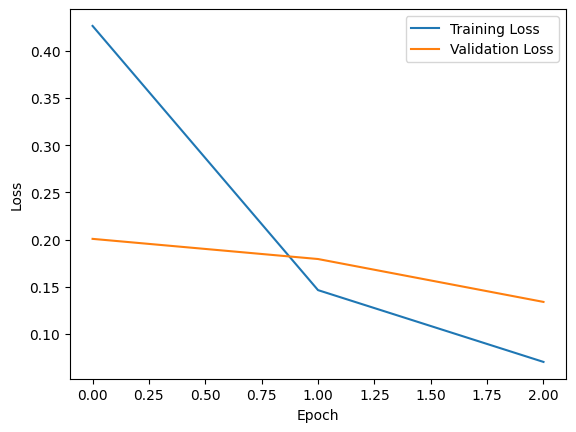

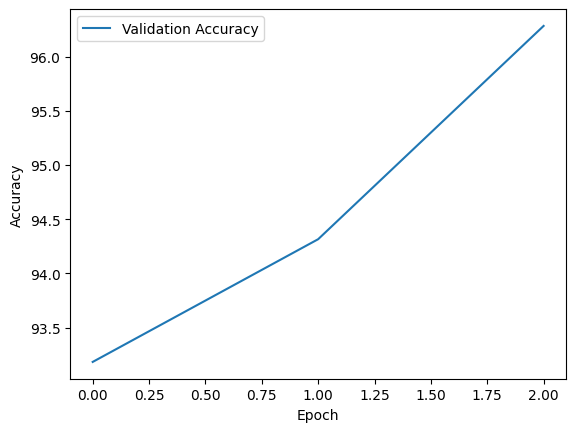

In [ ]:
# Early stopping parameters
patience = 2  # Number of epochs to wait for improvement
best_val_loss = float('inf')
patience_counter = 0
model_save_path = 'best_model_BERTweet_w_class_imbalance'

# Training and evaluation loop
training_stats = []
for epoch in range(3):  # specify the number of epochs
    model.train()
    total_train_loss = 0

    for step, batch in enumerate(train_dataloader):
        batch_input_ids, batch_attention_masks, batch_labels = batch
        optimizer.zero_grad()
        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_masks, labels=batch_labels)
        loss = outputs.loss
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()

        if step % 10 == 0:
            print(f"Epoch {epoch+1} Step {step}/{len(train_dataloader)} Loss {loss.item()}")

    avg_train_loss = total_train_loss / len(train_dataloader)

    # Validation loop
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0

    for batch in test_dataloader:
        batch_input_ids, batch_attention_masks, batch_labels = batch
        with torch.no_grad():
            outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_masks, labels=batch_labels)
        loss = outputs.loss
        logits = outputs.logits
        total_eval_loss += loss.item()

        preds = torch.argmax(logits, dim=1).flatten()
        accuracy = (preds == batch_labels).cpu().numpy().mean() * 100
        total_eval_accuracy += accuracy

    avg_val_accuracy = total_eval_accuracy / len(test_dataloader)
    avg_val_loss = total_eval_loss / len(test_dataloader)
    print(f"Epoch {epoch+1} Validation Accuracy: {avg_val_accuracy}")
    print(f"Epoch {epoch+1} Validation Loss: {avg_val_loss}")

    training_stats.append({
        'epoch': epoch + 1,
        'Training Loss': avg_train_loss,
        'Valid. Loss': avg_val_loss,
        'Valid. Accur.': avg_val_accuracy,
    })

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Save the best model
        model.save_pretrained(model_save_path)
        tokenizer.save_pretrained(model_save_path)
        print(f"Best model saved at epoch {epoch+1} with validation loss {avg_val_loss}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1} with best validation loss {best_val_loss}")
            break

print("Training complete.")

# Load the best model for further evaluation or use
model = RobertaForSequenceClassification.from_pretrained(model_save_path)
tokenizer = BertweetTokenizer.from_pretrained(model_save_path)

# Plot the training and validation loss
train_loss_values = [stat['Training Loss'] for stat in training_stats]
val_loss_values = [stat['Valid. Loss'] for stat in training_stats]

plt.plot(train_loss_values, label="Training Loss")
plt.plot(val_loss_values, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot the validation accuracy
val_accuracy_values = [stat['Valid. Accur.'] for stat in training_stats]

plt.plot(val_accuracy_values, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Inference data

In [ ]:
# Drop word_count column
validate_final_df.drop(columns=['word_count'], inplace=True)

In [ ]:
validate_final_df.columns

Index(['clean_text', 'label'], dtype='object')

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch.utils.data import DataLoader, TensorDataset

# Load the tokenizer from the saved files
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/Research NLP/BerTweet_w_class_imbalance/")

# Load the model from the saved files
model = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/Research NLP/BerTweet_w_class_imbalance/', local_files_only=True)

# Tokenize the validation data
def tokenize_data(texts, labels):
    input_ids = []
    attention_masks = []
    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=64,  # adjust this based on your data
            padding='max_length',  # updated for compatibility with newer versions
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)
    return input_ids, attention_masks, labels

# Tokenize the validation data
texts = validate_final_df['clean_text'].tolist()
labels = validate_final_df['label'].tolist()

validate_input_ids, validate_attention_masks, validate_labels = tokenize_data(texts, labels)

# Create DataLoader for the validation data
validate_dataset = TensorDataset(validate_input_ids, validate_attention_masks, validate_labels)
validate_dataloader = DataLoader(validate_dataset, batch_size=16, shuffle=False)

# Function to perform predictions
def predict(model, dataloader):
    model.eval()
    predictions, true_labels = [], []

    for batch in dataloader:
        batch_input_ids, batch_attention_masks, batch_labels = batch

        with torch.no_grad():
            outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_masks)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).flatten()

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(batch_labels.cpu().numpy())

    return predictions, true_labels

# Perform predictions on the validation data
predictions, true_labels = predict(model, validate_dataloader)

# Display results
result_df = validate_final_df.copy()
result_df['predicted_label'] = predictions
print(result_df)


                                             clean_text  label  \
0                 $ally - ally financial pulls outlook       0   
1     $dell $hpe - dell, hpe targets trimmed on comp...      0   
2         $prty - moody's turns negative on party city       0   
3                      $san: deutsche bank cuts to hold      0   
4                     $sitc: compass point cuts to sell      0   
...                                                 ...    ...   
4693              new dungeons & dragons game announced      2   
4694           nasdaq prices 600m senior notes offering      2   
4695  worker and environment safeguards among change...      2   
4696  wall street breakfast: merger monday. get more...      2   
4697  shareholders rejoice? hbc, canfor proxy wins d...      2   

      predicted_label  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  
...               ...  
4693                2  
4694           

In [ ]:
import pandas as pd
# Save data to location
result_df.to_csv("/content/drive/MyDrive/Research NLP/Results/bertweet_w_class_imbalance.csv", index=False)


In [ ]:
# Load model details
from transformers import AutoConfig

# Load the configuration from the saved model directory
config = AutoConfig.from_pretrained("/content/drive/MyDrive/Research NLP/BerTweet_w_class_imbalance/")

# Print the hyperparameters
print(config)


hidden_size = config.hidden_size
num_attention_heads = config.num_attention_heads
num_hidden_layers = config.num_hidden_layers

print(f"Hidden Size: {hidden_size}")
print(f"Number of Attention Heads: {num_attention_heads}")
print(f"Number of Hidden Layers: {num_hidden_layers}")


RobertaConfig {
  "_name_or_path": "/content/drive/MyDrive/Research NLP/BerTweet_w_class_imbalance/",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "tokenizer_class": "BertweetTokenizer",
  "torch_dtype": "float32",
  "transformers_version": "4.42.4",
  "type_vocab_size": 1,
  "use_cache":

In [ ]:
# Tokenize the validation data
def tokenize_data(texts, labels):
    input_ids = []
    attention_masks = []
    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=64,  # adjust this based on your data
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)
    return input_ids, attention_masks, labels

# Tokenize the validation data
texts = validate_final_df['clean_text'].tolist()
labels = validate_final_df['label'].tolist()

validate_input_ids, validate_attention_masks, validate_labels = tokenize_data(texts, labels)

# Create DataLoader for the validation data
validate_dataset = TensorDataset(validate_input_ids, validate_attention_masks, validate_labels)
validate_dataloader = DataLoader(validate_dataset, batch_size=16, shuffle=False)

# Function to perform predictions
def predict(model, dataloader):
    model.eval()
    predictions, true_labels = [], []

    for batch in dataloader:
        batch_input_ids, batch_attention_masks, batch_labels = batch

        with torch.no_grad():
            outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_masks)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).flatten()

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(batch_labels.cpu().numpy())

    return predictions, true_labels

# Perform predictions on the validation data
predictions, true_labels = predict(model, validate_dataloader)

# Display results
result_df = validate_final_df.copy()
result_df['predicted_label'] = predictions
print(result_df)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


                                             clean_text  label  \
0                 $ally - ally financial pulls outlook       0   
1     $dell $hpe - dell, hpe targets trimmed on comp...      0   
2         $prty - moody's turns negative on party city       0   
3                      $san: deutsche bank cuts to hold      0   
4                     $sitc: compass point cuts to sell      0   
...                                                 ...    ...   
4693              new dungeons & dragons game announced      2   
4694           nasdaq prices 600m senior notes offering      2   
4695  worker and environment safeguards among change...      2   
4696  wall street breakfast: merger monday. get more...      2   
4697  shareholders rejoice? hbc, canfor proxy wins d...      2   

      predicted_label  
0                   2  
1                   2  
2                   2  
3                   2  
4                   2  
...               ...  
4693                2  
4694           

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Extract actual and predicted labels
y_true = result_df['label']
y_pred = result_df['predicted_label']

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
conf_matrix = confusion_matrix(y_true, y_pred)

# Display metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.8810131971051511
Precision: 0.8871457052738029
Recall: 0.8810131971051511
F1 Score: 0.8819169367894704
Confusion Matrix:
 [[1341   38  187]
 [  40 1359  167]
 [  61   66 1439]]


Interpretation of model results

1. Accuracy (0.8810):

  This metric indicates that the model correctly predicts the outcome for about 88.1% of the data. While this shows the model's overall effectiveness, accuracy alone may not fully capture the model's performance, especially in cases where the dataset has imbalanced classes or where the costs of different types of errors vary.
2. Precision (0.8871):

  Precision reflects the proportion of true positive predictions among all positive predictions made by the model, with a value of 88.7%. This high precision suggests that the model is quite effective at minimizing false positives, which is crucial in scenarios where incorrect positive predictions carry significant consequences.
3. Recall (0.8810):

  Recall, at 88.1%, indicates the model's ability to correctly identify actual positive instances from the dataset. This is particularly important in contexts where missing true positives (false negatives) could lead to significant issues, such as in medical diagnoses or fraud detection.

4. F1 Score (0.8819):

  The F1 score, which balances precision and recall, is 88.2%. This metric provides a single measure that accounts for both false positives and false negatives, making it a valuable indicator of the model's performance when the class distribution is uneven or when both types of errors are costly.
5. Confusion Matrix:

  The confusion matrix reveals the model's performance across different classes:
  Class 1: The model correctly identifies 1,341 instances as Class 1 but misclassifies 38 as Class 2 and 187 as Class 3. This suggests a good but not perfect ability to distinguish Class 1 from others.
  Class 2: There are 1,359 correct predictions for Class 2, with 40 instances mistakenly identified as Class 1 and 167 as Class 3. This shows that while the model performs well, there is still some confusion between Classes 2 and 3.
  Class 3: For Class 3, 1,439 instances are correctly classified, with 61 incorrectly labeled as Class 1 and 66 as Class 2. This indicates that Class 3 is generally well-identified, though some instances are misclassified as other classes.
  Overall Summary:
    The model shows strong performance across all metrics, with balanced precision and recall, leading to a solid F1 score. However, the confusion matrix highlights specific areas where the model struggles to distinguish between certain classes. These misclassifications suggest opportunities for further refinement, such as adjusting the model's parameters or exploring additional features, to improve its ability to correctly differentiate between closely related classes. This fine-tuning could enhance the model’s overall accuracy and make it more reliable in practical applications.